### Imports

In [1]:
import sys
mypath = "/home/basia/Documents/spectroscopy/magnetstein"
sys.path.insert(0, mypath)

In [2]:
import numpy as np
import pandas as pd
import os
from masserstein import NMRSpectrum, estimate_proportions
import matplotlib.pyplot as plt
import pulp
import pickle

### Data

In [3]:
experiment_name = 'PMG 284 monitoring'
products = 'known_products'

In [4]:
mixture_paths = {'Saccharose hydrolysis': '../data/saccharose_1000/all.csv',
                'Silane': '../data/silan/pmg166_3rdseries_full.csv',
                'PMG 247 monitoring': '../data/PMG_247/preprocessed_PMG247_monitoring.csv',
                'PMG 271 monitoring': '../data/PMG_271/PMG271_monitoring_druga_seria.csv',
                'PMG 284 monitoring': '../data/PMG_284/seria1.csv',
                'PMG 287 monitoring': '../data/PMG_287/preprocessed_mixture.csv'
                }

reagents_paths = {'Saccharose hydrolysis': ['../data/saccharose_1000/sucrose.csv', 
                                            '../data/saccharose_1000/glucose.csv',
                                            '../data/saccharose_1000/fructose.csv'],
                'Silane': [],
                'PMG 247 monitoring': ['../data/PMG_247/preprocessed_substrate0.csv',
                                      '../data/PMG_247/preprocessed_substrate1.csv',
                                      'product_path'],
                'PMG 271 monitoring': ['../data/PMG_271/preprocessed_substrate0.csv',
                                      '../data/PMG_271/preprocessed_substrate1.csv',
                                      'product_path'],
                'PMG 284 monitoring': ['../data/PMG_284/preprocessed_substrate0.csv',
                                      '../data/PMG_284/preprocessed_substrate1.csv',
                                      '../data/PMG_284/preprocessed_product.csv'],
                'PMG 287 monitoring': ['../data/PMG_287/preprocessed_substrate0.csv',
                                      '../data/PMG_287/preprocessed_substrate1.csv',
                                      '../data/PMG_287/preprocessed_product.csv']}

mixture_separators = {'Saccharose hydrolysis': '\t',
                'Silane': '\t',
                'PMG 247 monitoring': ',',
                'PMG 271 monitoring': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

reagents_separators = {'Saccharose hydrolysis': '\t',
                'Silane': '\t',
                'PMG 247 monitoring': '\t',
                'PMG 271 monitoring': '\t',
                'PMG 284 monitoring': '\t',
                'PMG 287 monitoring': '\t'
                }

results_paths = {'Saccharose hydrolysis': '../results/saccharose_1000/comparing_with_first/'+products+'/',
                'Silane': '../results/silan/comparing_with_first/'+products+'/',
                'PMG 247 monitoring': '../results/PMG_247/comparing_with_first/'+products+'/',
                'PMG 271 monitoring': '../results/PMG_271/comparing_with_first/'+products+'/',
                'PMG 284 monitoring': '../results/PMG_284/comparing_with_first/'+products+'/',
                'PMG 287 monitoring': '../results/PMG_287/comparing_with_first/'+products+'/'}

#### Mixture in time

In [5]:
mixture_time_data = pd.read_csv(mixture_paths[experiment_name], sep = mixture_separators[experiment_name])
if experiment_name == 'Saccharose hydrolysis':
    mixture_time_data = mixture_time_data.iloc[:,:-1]
elif experiment_name == 'PMG 271 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_20th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::20]
    mixture_time_data = pd.concat((ppm, every_20th), axis=1)
elif experiment_name == 'PMG 284 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)
elif experiment_name == 'PMG 287 monitoring':
    ppm = mixture_time_data.iloc[:,:-1].iloc[:,0:1]
    every_10th = mixture_time_data = mixture_time_data.iloc[:,:-1].iloc[:,1:].iloc[:,::10]
    mixture_time_data = pd.concat((ppm, every_10th), axis=1)

In [6]:
names = ['ppm'] + ['t' + str(nb) for nb in range(1, mixture_time_data.shape[1])]

In [7]:
mixture_time_data.columns = names

In [8]:
def load_spectrum(mixture_time_data, moment_of_time):
    ppm = mixture_time_data['ppm']
    intensity = mixture_time_data['t'+str(moment_of_time)]
    sp = NMRSpectrum(confs = list(zip(ppm, intensity)))
    sp.trim_negative_intensities()
    sp.normalize()
    return sp

#### Reagents

In [9]:
reagents_spectra = []
for reagent in reagents_paths[experiment_name]:
    reag = pd.read_csv(reagent, sep=reagents_separators[experiment_name], header=None).iloc[:,:2]
    reagents_spectra.append(reag)

In [10]:
reagents_spectra2 = []
for reag in reagents_spectra:
    ppm = reag.iloc[:,0]
    ints = reag.iloc[:,1]
    sp = NMRSpectrum(confs = list(zip(ppm, ints)))
    reagents_spectra2.append(sp)
reagents_spectra = reagents_spectra2
del(reagents_spectra2)

In [11]:
for sp in reagents_spectra:
    sp.trim_negative_intensities()
    sp.normalize()

In [12]:
if products == 'unknown_products':
    if experiment_name == 'Saccharose hydrolysis':
        reagents_spectra = reagents_spectra[:-2]
    else:
        reagents_spectra = reagents_spectra[:-1]

In [13]:
%matplotlib notebook

<IPython.core.display.Javascript object>


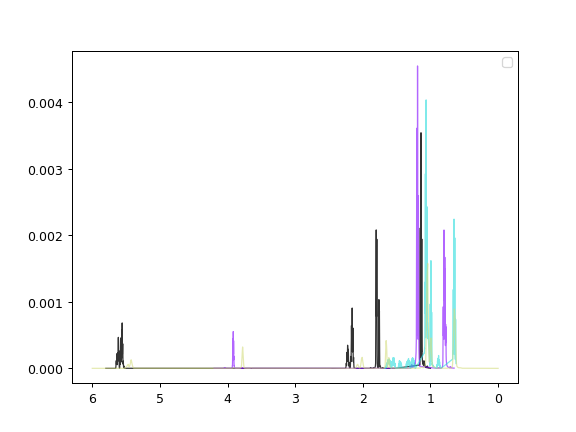

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [14]:
plt.gca().invert_xaxis()
NMRSpectrum.plot_all(reagents_spectra + [load_spectrum(mixture_time_data, 1)], profile=True)

### Estimation

In [15]:
kappa = 0.1
kappa_th = 1.15

In [16]:
proportions_in_times = []
noise_proportions_in_times = []
noise = []
noise_in_components = []

for i in range(1, mixture_time_data.shape[1]):
    print('This is timepoint '+str(i)+'.\n')
    mix = load_spectrum(mixture_time_data, i)
    mix.trim_negative_intensities()
    mix.normalize()
    estimation = estimate_proportions(mix, reagents_spectra, what_to_compare='area', 
                                      solver=pulp.GUROBI(msg=False),
                                     MTD=kappa, MTD_th=kappa_th)
    proportions_in_times.append(estimation['proportions'])
    noise_proportions_in_times.append(estimation['proportion_of_noise_in_components'])
    noise.append(estimation['noise'])
    noise_in_components.append(estimation['noise_in_components'])
    if i>1:
        assert estimation['common_horizontal_axis'] == common_horizontal_axis
    common_horizontal_axis = estimation['common_horizontal_axis']
    
    print('Proportions:\n')
    print(estimation['proportions'])
    print('\n')
    print('Proportion_of_noise_in_components:\n')
    print(estimation['proportion_of_noise_in_components'])
    print('\n')

This is timepoint 1.

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Proportions:

[0.0022608460280000115, 0.0, 0.7608250702060039]


Proportion_of_noise_in_components:

0.0


This is timepoint 2.

Proportions:

[0.016225699975000157, 0.0, 0.7526562116850072]


Proportion_of_noise_in_components:

0.0


This is timepoint 3.

Proportions:

[0.011154731053000001, 0.0, 0.7601141653430002]


Proportion_of_noise_in_components:

0.0


This is timepoint 4.

Proportions:

[0.012004376656000059, 0.0, 0.7608673326700036]


Proportion_of_noise_in_components:

0.0


This is timepoint 5.

Proportions:

[0.005330228733000016, 0.0, 0.7705320090560022]


Proportion_of_noise_in_components:

0.0


This is timepoint 6.

Proportions:

[0.005071559815000008, 0.0, 0.7725041126510014]


Proportion_of_noise_in_components:

0.0


This is timepoint 7.

Proportions:

[0.004769120876999994, 0.0, 0.773342810001999]


Proportion_of_noise_in_components:

0.0


This is timepoint 8.

Proportions:

[0.0037076643350000367, 0.0, 0.7738020445600078]


Proportion_of_noise_in_components:

0.0

Proportions:

[0.002216878205999995, 0.0, 0.8264372276299983]


Proportion_of_noise_in_components:

0.0


This is timepoint 66.

Proportions:

[0.0006577855530000043, 0.0, 0.8225070493800054]


Proportion_of_noise_in_components:

0.0


This is timepoint 67.

Proportions:

[0.000541810801999999, 0.0, 0.8206818163299984]


Proportion_of_noise_in_components:

0.0


This is timepoint 68.

Proportions:

[0.0006243194110000024, 0.0, 0.8241411754100031]


Proportion_of_noise_in_components:

0.0


This is timepoint 69.

Proportions:

[0.0004503272829999997, 0.0, 0.8218464341749996]


Proportion_of_noise_in_components:

0.0


This is timepoint 70.

Proportions:

[0.00044644222099999973, 0.0, 0.8216844493039994]


Proportion_of_noise_in_components:

0.0


This is timepoint 71.

Proportions:

[0.0005486910389999982, 0.0, 0.8234530278799973]


Proportion_of_noise_in_components:

0.0


This is timepoint 72.

Proportions:

[0.000529154496999999, 0.0, 0.8235081448749985]


Proportion_of_noise_in_comp

In [17]:
len(proportions_in_times)

100

<IPython.core.display.Javascript object>


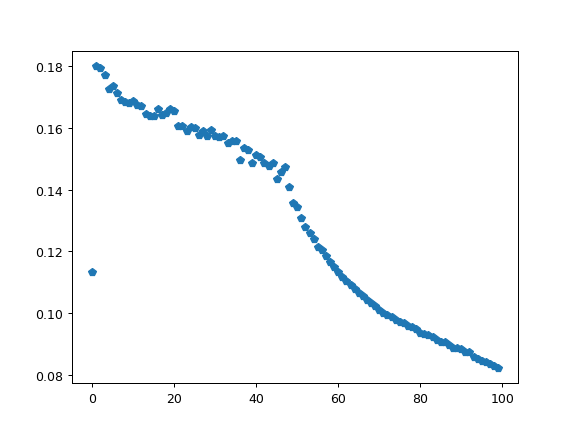

In [18]:
plt.plot(range(len(proportions_in_times)), [prop[0] for prop in proportions_in_times], 'p')

In [17]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(proportions_in_times, f)

In [18]:
with open(results_paths[experiment_name]+'noise_proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_proportions_in_times, f)

In [19]:
with open(results_paths[experiment_name]+'common_horizontal_axis_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(common_horizontal_axis, f)

In [20]:
with open(results_paths[experiment_name]+'noise_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise, f)

In [21]:
with open(results_paths[experiment_name]+'noise_in_components_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'wb') as f:
    pickle.dump(noise_in_components, f)

### Linear regression

In [34]:
with open(results_paths[experiment_name]+'proportions_in_times_'+str(kappa)+'_'+str(kappa_th)+'.pkl', 'rb') as f:
    y = pickle.load(f)
    y = np.array(y)

In [35]:
t = np.array(range(1, y.shape[0]+1))
t_and_ones = np.vstack([t, np.ones(len(t))]).T

In [36]:
reagent_number = 1

In [37]:
slope, intercept = np.linalg.lstsq(t_and_ones, y)[0][:,reagent_number]

/tmp/ipykernel_5844/1931212556.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, intercept = np.linalg.lstsq(t_and_ones, y)[0][:,reagent_number]


<IPython.core.display.Javascript object>


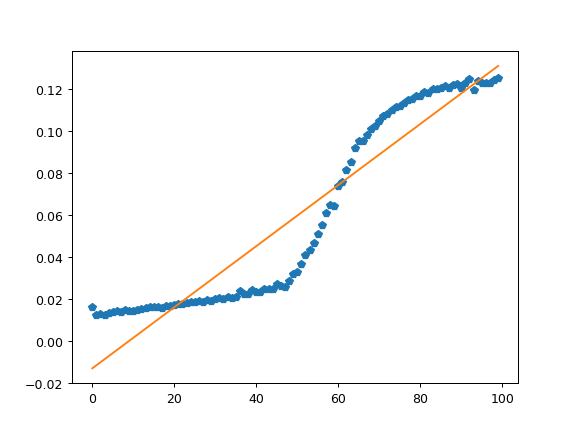

In [38]:
plt.plot(range(len(y)), [prop[reagent_number] for prop in y], 'p')
plt.plot(slope*t+intercept)